[*********************100%***********************]  1 of 1 completed

x_train: (2867, 100, 1), y_train: (2867, 90, 1)
x_test: (717, 100, 1), y_test: (717, 90, 1)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 64)             │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector_1 (RepeatVector)  │ (None, 90, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 90, 64)         │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, 90, 1)          │            65 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 49,985 (195.25 KB)

 Trainable params: 49,985 (195.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 28s 163ms/step - loss: 0.0122 - val_loss: 0.0119
Epoch 2/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 11s 120ms/step - loss: 0.0011 - val_loss: 0.0093
Epoch 3/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 11s 116ms/step - loss: 8.7529e-04 - val_loss: 0.0079
Epoch 4/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 10s 115ms/step - loss: 9.3753e-04 - val_loss: 0.0069
Epoch 5/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 11s 118ms/step - loss: 7.1409e-04 - val_loss: 0.0098
Epoch 6/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 11s 122ms/step - loss: 7.7444e-04 - val_loss: 0.0151
Epoch 7/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 11s 118ms/step - loss: 6.6785e-04 - val_loss: 0.6569
Epoch 8/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 11s 117ms/step - loss: 7.1146e-04 - val_loss: 0.0319
Epoch 9/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 21s 120ms/step - loss: 7.2302e-04 - val_loss: 2.7788
Epoch 10/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 11s 121ms/step - loss: 6.2035e-04 - val_loss: 6.1067
Epoch 11/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 10s 113ms/step - loss: 7.0589e-04 - val_loss: 0.6918
Epoch

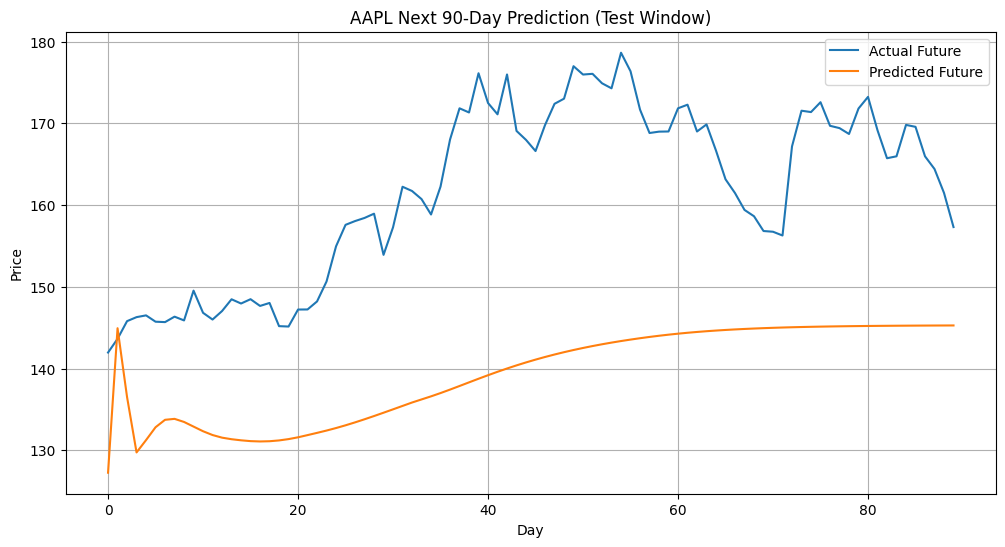

Test MAE: 20.50, Test RMSE: 25.81
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


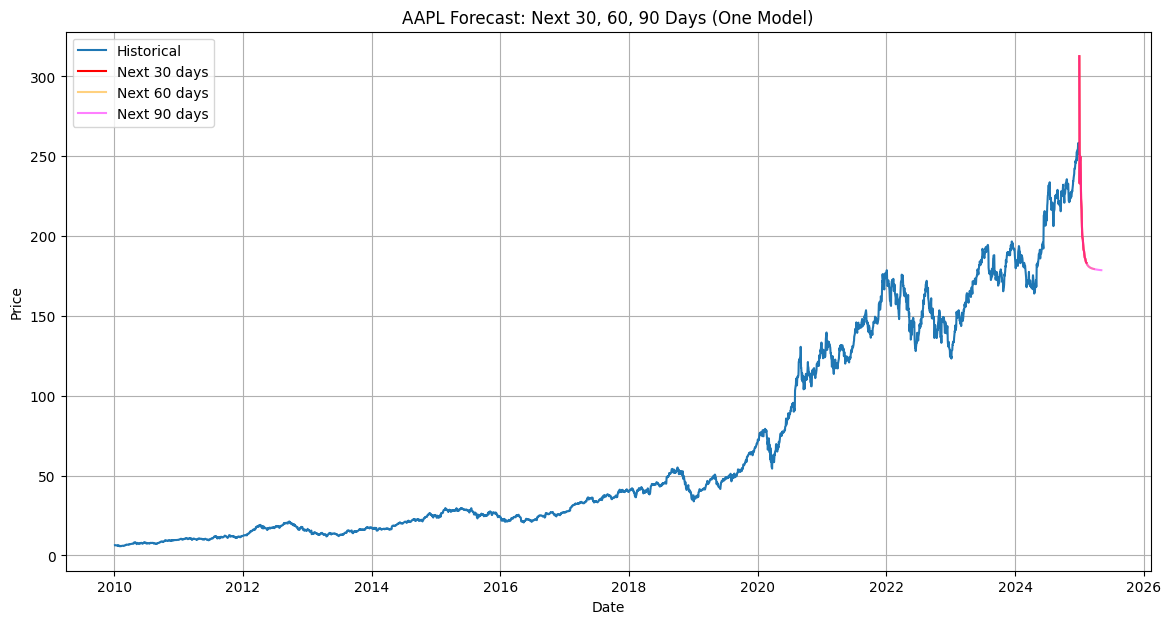

Model saved as 'seq2seq_lstm_stock_forecast.h5'


In [ ]:
# 1. Install and import
# !pip install yfinance scikit-learn keras matplotlib pandas

import numpy as np # Ensure you have the required libraries installed
import pandas as pd  # For data manipulation and analysis
import warnings# Suppress warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt # For plotting
import yfinance as yf # For downloading stock data 
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, RepeatVector, TimeDistributed

# 2. Download data
TICKER = 'AAPL'
START = '2010-01-01'
END = '2024-12-31'
df = yf.download(TICKER, start=START, end=END)
df = df[['Close']].dropna()

# 3. Prepare data for seq2seq LSTM
N_STEPS_IN = 100    # How many days to use for prediction
N_STEPS_OUT = 90    # Predict next 90 days (can extract 30, 60 as needed)

scaler = MinMaxScaler()
scaled_close = scaler.fit_transform(df['Close'].values.reshape(-1, 1))

# Create input/output sequences
X, Y = [], []
for i in range(N_STEPS_IN, len(scaled_close) - N_STEPS_OUT + 1):
    X.append(scaled_close[i-N_STEPS_IN:i, 0])
    Y.append(scaled_close[i:i+N_STEPS_OUT, 0])
X = np.array(X)
Y = np.array(Y)
X = X.reshape((X.shape[0], N_STEPS_IN, 1))
Y = Y.reshape((Y.shape[0], N_STEPS_OUT, 1))

# 4. Train/Test split
split_idx = int(0.8 * len(X))
x_train, x_test = X[:split_idx], X[split_idx:]
y_train, y_test = Y[:split_idx], Y[split_idx:]

print(f"x_train: {x_train.shape}, y_train: {y_train.shape}")
print(f"x_test: {x_test.shape}, y_test: {y_test.shape}")

# 5. Build and train model
model = Sequential([
    LSTM(64, activation='relu', input_shape=(N_STEPS_IN, 1)),
    RepeatVector(N_STEPS_OUT),
    LSTM(64, activation='relu', return_sequences=True),
    TimeDistributed(Dense(1))
])
model.compile(optimizer='adam', loss='mse')
model.summary()

history = model.fit(x_train, y_train, epochs=20, batch_size=32, 
                    validation_data=(x_test, y_test))

# 6. Evaluate on test set (predict next 90 days for known windows)
test_pred_scaled = model.predict(x_test)
test_pred = scaler.inverse_transform(test_pred_scaled.reshape(-1, N_STEPS_OUT))
y_test_orig = scaler.inverse_transform(y_test.reshape(-1, N_STEPS_OUT))

# Plot one example: true vs. predicted next 90 days
example = 0  # You can pick any example from the test set
plt.figure(figsize=(12,6))
plt.plot(range(N_STEPS_OUT), y_test_orig[example], label='Actual Future')
plt.plot(range(N_STEPS_OUT), test_pred[example], label='Predicted Future')
plt.title(f"{TICKER} Next 90-Day Prediction (Test Window)")
plt.xlabel("Day")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.show()

# 7. Calculate test MAE, RMSE for all test windows
from sklearn.metrics import mean_absolute_error, mean_squared_error
mae = mean_absolute_error(y_test_orig, test_pred)
rmse = np.sqrt(mean_squared_error(y_test_orig, test_pred))
print(f"Test MAE: {mae:.2f}, Test RMSE: {rmse:.2f}")

# 8. Predict next 90 days for the real (unknown) future
last_seq = scaled_close[-N_STEPS_IN:].reshape(1, N_STEPS_IN, 1)
future_pred_scaled = model.predict(last_seq)
future_pred = scaler.inverse_transform(future_pred_scaled.reshape(-1, 1)).flatten()

future_dates = pd.date_range(df.index[-1] + pd.Timedelta(days=1), periods=N_STEPS_OUT, freq='B')

# 9. Plot next 30, 60, 90 days
plt.figure(figsize=(14,7))
plt.plot(df.index, df['Close'], label='Historical')
plt.plot(future_dates[:30], future_pred[:30], label='Next 30 days', color='red')
plt.plot(future_dates[:60], future_pred[:60], label='Next 60 days', color='orange', alpha=0.5)
plt.plot(future_dates, future_pred, label='Next 90 days', color='magenta', alpha=0.5)
plt.title(f"{TICKER} Forecast: Next 30, 60, 90 Days (One Model)")
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid()
plt.show()
# 10. Save the model
model.save('seq2seq_lstm_stock_forecast.h5')
print("Model saved as 'seq2seq_lstm_stock_forecast.h5'")

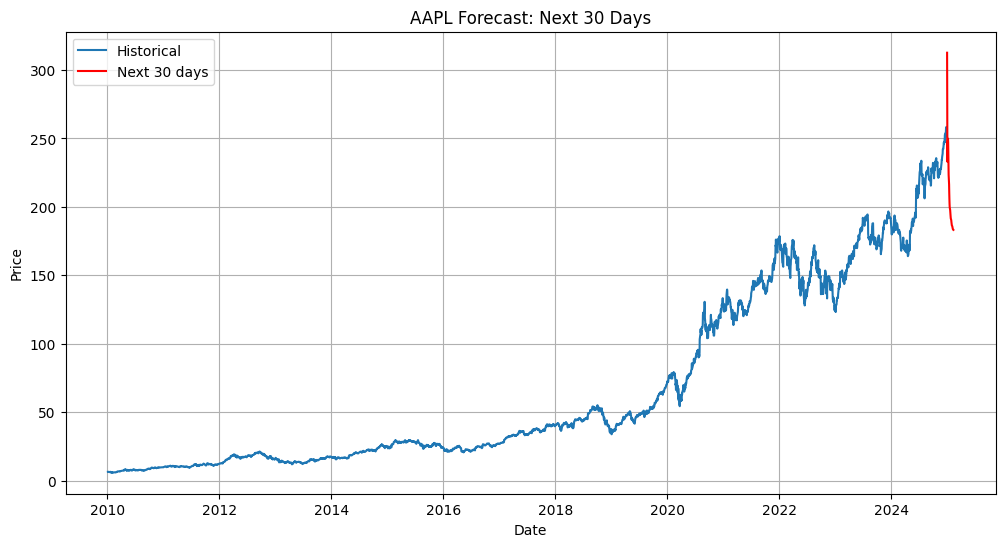

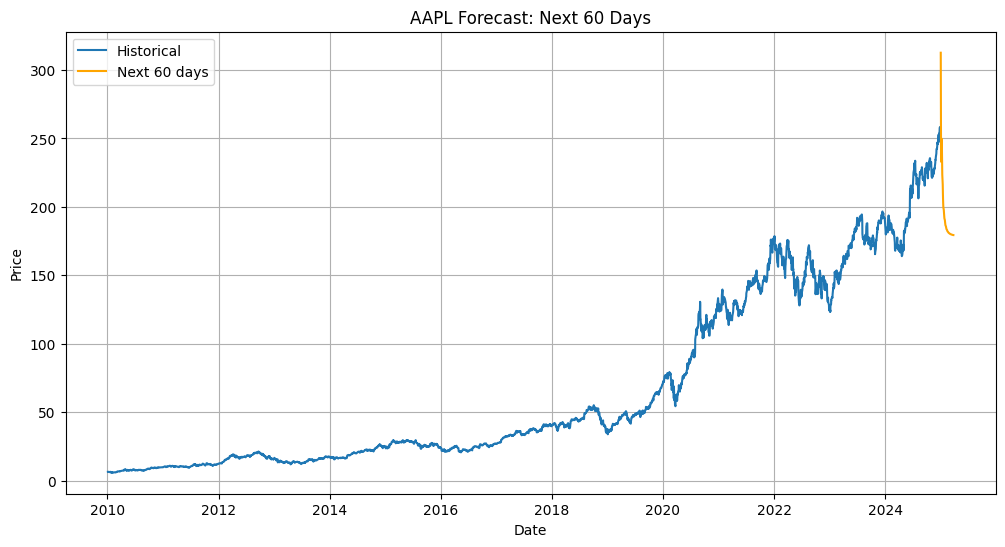

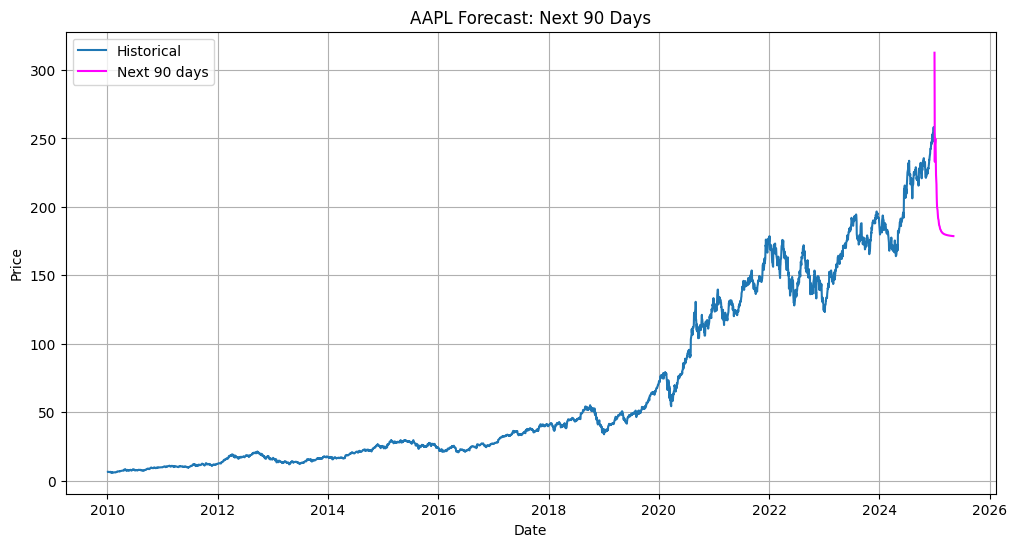

In [5]:
# Historical data for plotting
historical_dates = df.index
historical_prices = df['Close']

# Next 30 days forecast
plt.figure(figsize=(12, 6))
plt.plot(historical_dates, historical_prices, label='Historical')
plt.plot(future_dates[:30], future_pred[:30], color='red', label='Next 30 days')
plt.title('AAPL Forecast: Next 30 Days')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

# Next 60 days forecast
plt.figure(figsize=(12, 6))
plt.plot(historical_dates, historical_prices, label='Historical')
plt.plot(future_dates[:60], future_pred[:60], color='orange', label='Next 60 days')
plt.title('AAPL Forecast: Next 60 Days')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

# Next 90 days forecast
plt.figure(figsize=(12, 6))
plt.plot(historical_dates, historical_prices, label='Historical')
plt.plot(future_dates, future_pred, color='magenta', label='Next 90 days')
plt.title('AAPL Forecast: Next 90 Days')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

[*********************100%***********************]  1 of 1 completed

x_train: (2867, 100, 1), y_train: (2867, 90, 1)
x_test: (717, 100, 1), y_test: (717, 90, 1)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                   │ (None, 64)             │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector_2 (RepeatVector)  │ (None, 90, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 90, 64)         │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_2              │ (None, 90, 1)          │            65 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 49,985 (195.25 KB)

 Trainable params: 49,985 (195.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 26s 140ms/step - loss: 0.0141 - val_loss: 0.0144
Epoch 2/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 10s 113ms/step - loss: 0.0011 - val_loss: 0.0146
Epoch 3/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 10s 114ms/step - loss: 8.6745e-04 - val_loss: 0.0064
Epoch 4/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 11s 121ms/step - loss: 7.7435e-04 - val_loss: 0.0061
Epoch 5/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 11s 125ms/step - loss: 7.5601e-04 - val_loss: 0.0064
Epoch 6/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 11s 115ms/step - loss: 6.8456e-04 - val_loss: 0.0058
Epoch 7/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 11s 122ms/step - loss: 6.2888e-04 - val_loss: 0.0068
Epoch 8/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 10s 112ms/step - loss: 6.1276e-04 - val_loss: 0.0057
Epoch 9/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 11s 117ms/step - loss: 6.1540e-04 - val_loss: 0.0051
Epoch 10/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 11s 123ms/step - loss: 6.6212e-04 - val_loss: 0.0060
Epoch 11/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 10s 116ms/step - loss: 5.9623e-04 - val_loss: 0.0053
Epoch

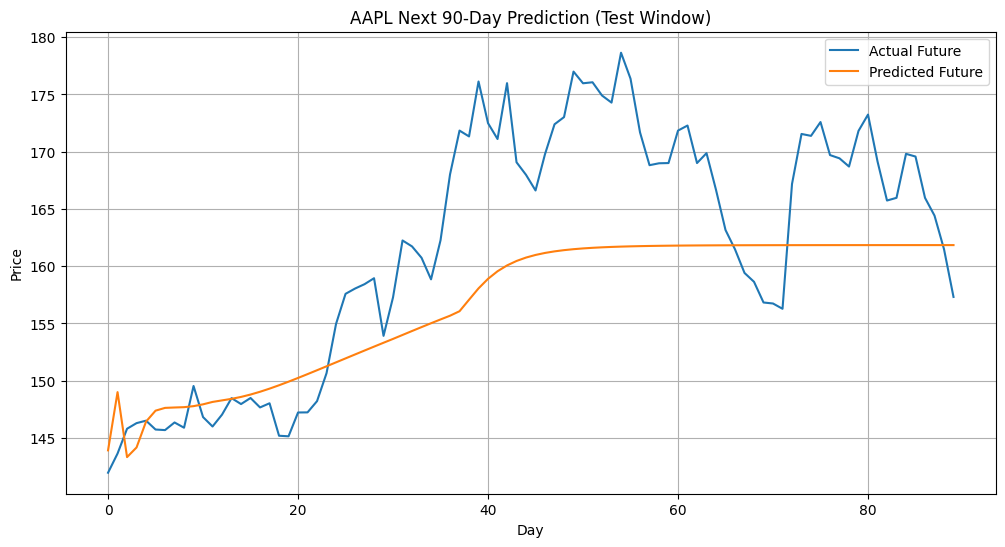

Test MAE: 16.93, Test RMSE: 21.18
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


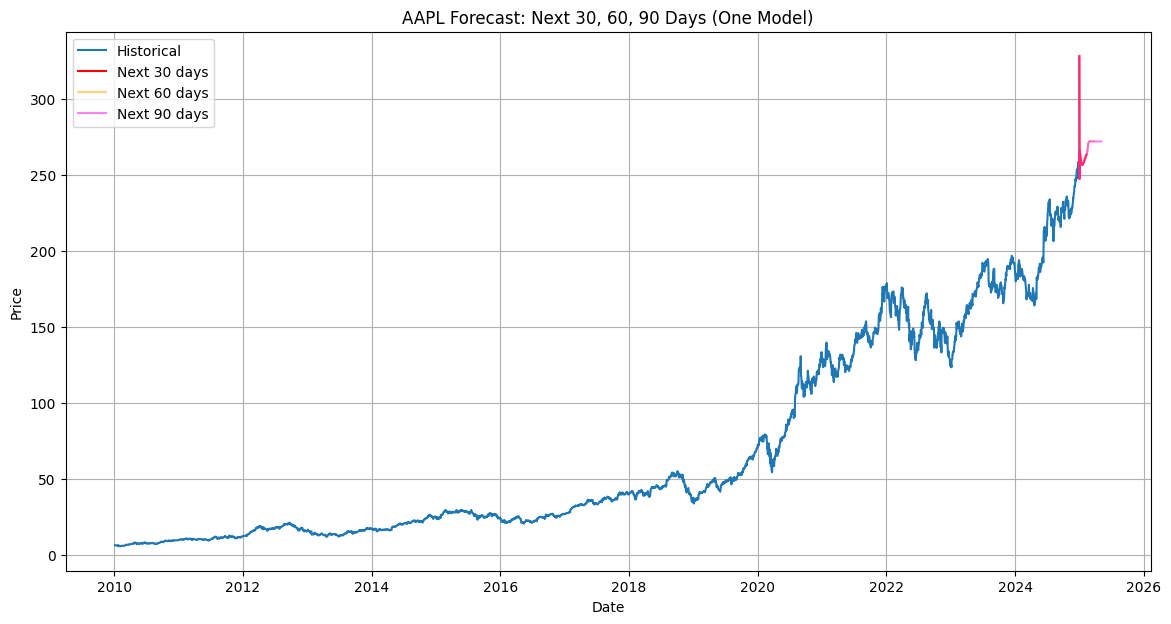

Model saved as 'seq2seq_lstm_stock_forecast.h5'


In [7]:
# 1. Install and import
# !pip install yfinance scikit-learn keras matplotlib pandas

import numpy as np # Ensure you have the required libraries installed
import pandas as pd  # For data manipulation and analysis
import warnings# Suppress warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt # For plotting
import yfinance as yf # For downloading stock data 
import keras 
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, RepeatVector, TimeDistributed

# 2. Download data
TICKER = 'AAPL'
START = '2010-01-01'
END = '2024-12-31'
df = yf.download(TICKER, start=START, end=END)
df = df[['Close']].dropna()

# 3. Prepare data for seq2seq LSTM
N_STEPS_IN = 100    # How many days to use for prediction
N_STEPS_OUT = 90    # Predict next 90 days (can extract 30, 60 as needed)

scaler = MinMaxScaler()
scaled_close = scaler.fit_transform(df['Close'].values.reshape(-1, 1))

# Create input/output sequences
X, Y = [], []
for i in range(N_STEPS_IN, len(scaled_close) - N_STEPS_OUT + 1):
    X.append(scaled_close[i-N_STEPS_IN:i, 0])
    Y.append(scaled_close[i:i+N_STEPS_OUT, 0])
X = np.array(X)
Y = np.array(Y)
X = X.reshape((X.shape[0], N_STEPS_IN, 1))
Y = Y.reshape((Y.shape[0], N_STEPS_OUT, 1))

# 4. Train/Test split
split_idx = int(0.8 * len(X))
x_train, x_test = X[:split_idx], X[split_idx:]
y_train, y_test = Y[:split_idx], Y[split_idx:]

print(f"x_train: {x_train.shape}, y_train: {y_train.shape}")
print(f"x_test: {x_test.shape}, y_test: {y_test.shape}")

# 5. Build and train model
model = Sequential([
    LSTM(64, activation='relu', input_shape=(N_STEPS_IN, 1)),
    RepeatVector(N_STEPS_OUT),
    LSTM(64, activation='relu', return_sequences=True),
    TimeDistributed(Dense(1))
])
model.compile(optimizer='adam', loss=keras.losses.MeanSquaredError())
model.summary()

history = model.fit(x_train, y_train, epochs=20, batch_size=32, 
                    validation_data=(x_test, y_test))

# 6. Evaluate on test set (predict next 90 days for known windows)
test_pred_scaled = model.predict(x_test)
test_pred = scaler.inverse_transform(test_pred_scaled.reshape(-1, N_STEPS_OUT))
y_test_orig = scaler.inverse_transform(y_test.reshape(-1, N_STEPS_OUT))

# Plot one example: true vs. predicted next 90 days
example = 0  # You can pick any example from the test set
plt.figure(figsize=(12,6))
plt.plot(range(N_STEPS_OUT), y_test_orig[example], label='Actual Future')
plt.plot(range(N_STEPS_OUT), test_pred[example], label='Predicted Future')
plt.title(f"{TICKER} Next 90-Day Prediction (Test Window)")
plt.xlabel("Day")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.show()

# 7. Calculate test MAE, RMSE for all test windows
from sklearn.metrics import mean_absolute_error, mean_squared_error
mae = mean_absolute_error(y_test_orig, test_pred)
rmse = np.sqrt(mean_squared_error(y_test_orig, test_pred))
print(f"Test MAE: {mae:.2f}, Test RMSE: {rmse:.2f}")

# 8. Predict next 90 days for the real (unknown) future
last_seq = scaled_close[-N_STEPS_IN:].reshape(1, N_STEPS_IN, 1)
future_pred_scaled = model.predict(last_seq)
future_pred = scaler.inverse_transform(future_pred_scaled.reshape(-1, 1)).flatten()

future_dates = pd.date_range(df.index[-1] + pd.Timedelta(days=1), periods=N_STEPS_OUT, freq='B')

# 9. Plot next 30, 60, 90 days
plt.figure(figsize=(14,7))
plt.plot(df.index, df['Close'], label='Historical')
plt.plot(future_dates[:30], future_pred[:30], label='Next 30 days', color='red')
plt.plot(future_dates[:60], future_pred[:60], label='Next 60 days', color='orange', alpha=0.5)
plt.plot(future_dates, future_pred, label='Next 90 days', color='magenta', alpha=0.5)
plt.title(f"{TICKER} Forecast: Next 30, 60, 90 Days (One Model)")
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid()
plt.show()
# 10. Save the model
model.save('seq2seq_lstm_stock_forecast.h5')
print("Model saved as 'seq2seq_lstm_stock_forecast.h5'")

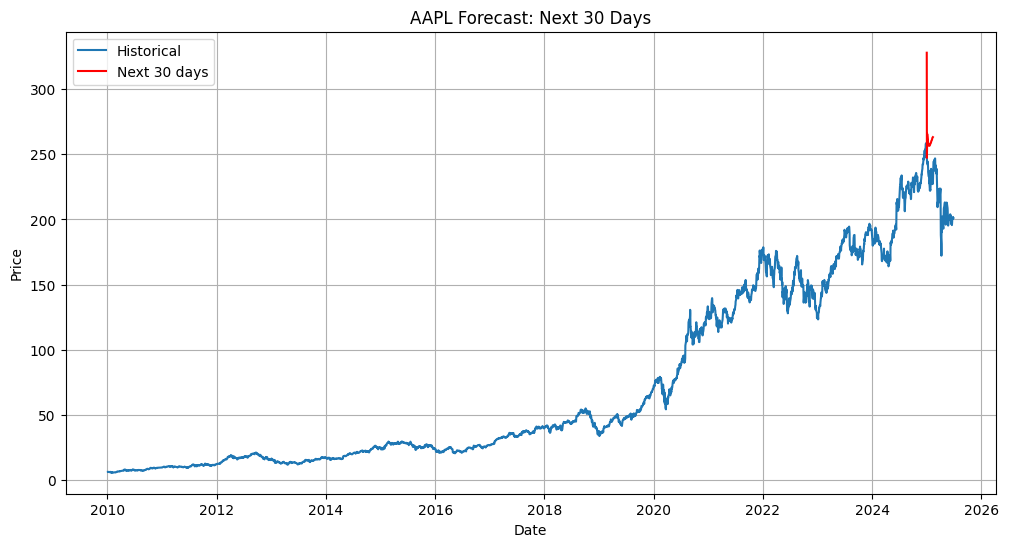

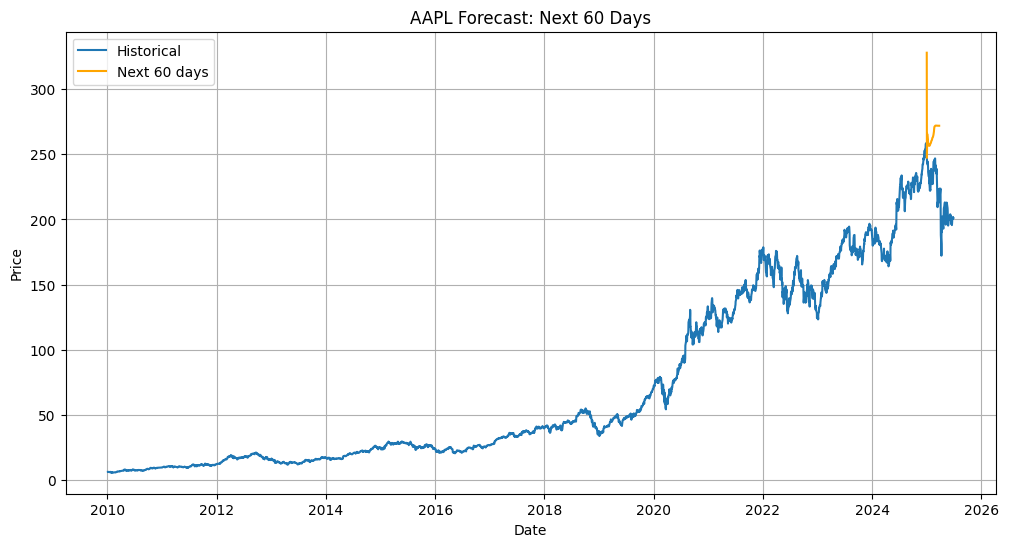

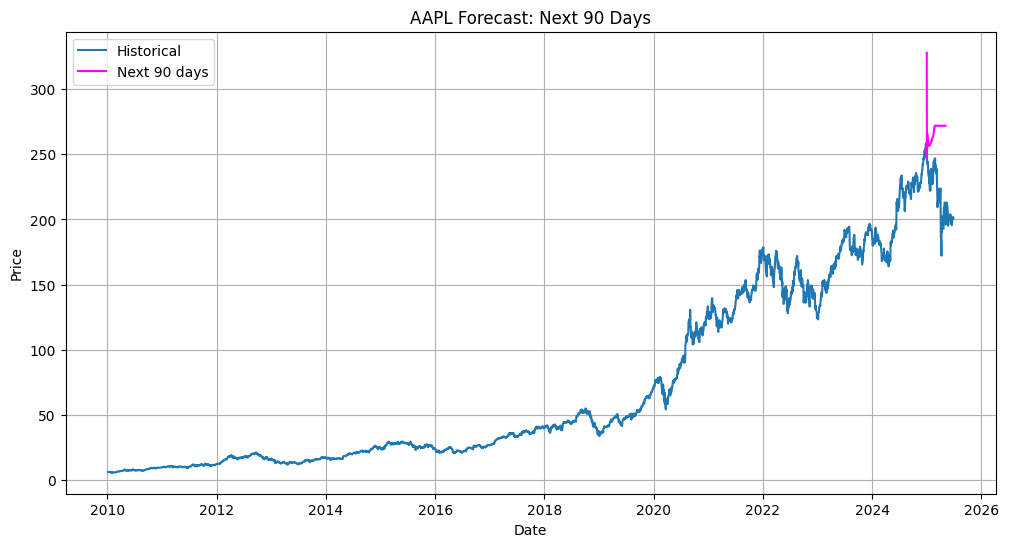

In [9]:
# Historical data for plotting
historical_dates = df.index
historical_prices = df['Close']

# Next 30 days forecast
plt.figure(figsize=(12, 6))
plt.plot(historical_dates, historical_prices, label='Historical')
plt.plot(future_dates[:30], future_pred[:30], color='red', label='Next 30 days')
plt.title('AAPL Forecast: Next 30 Days')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

# Next 60 days forecast
plt.figure(figsize=(12, 6))
plt.plot(historical_dates, historical_prices, label='Historical')
plt.plot(future_dates[:60], future_pred[:60], color='orange', label='Next 60 days')
plt.title('AAPL Forecast: Next 60 Days')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

# Next 90 days forecast
plt.figure(figsize=(12, 6))
plt.plot(historical_dates, historical_prices, label='Historical')
plt.plot(future_dates, future_pred, color='magenta', label='Next 90 days')
plt.title('AAPL Forecast: Next 90 Days')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

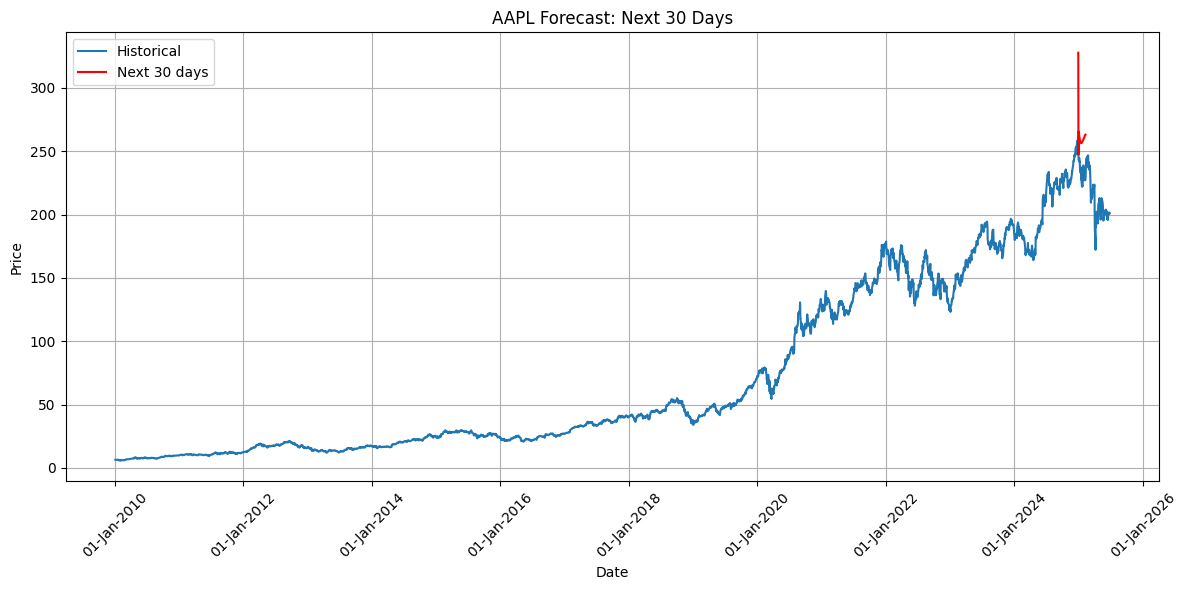

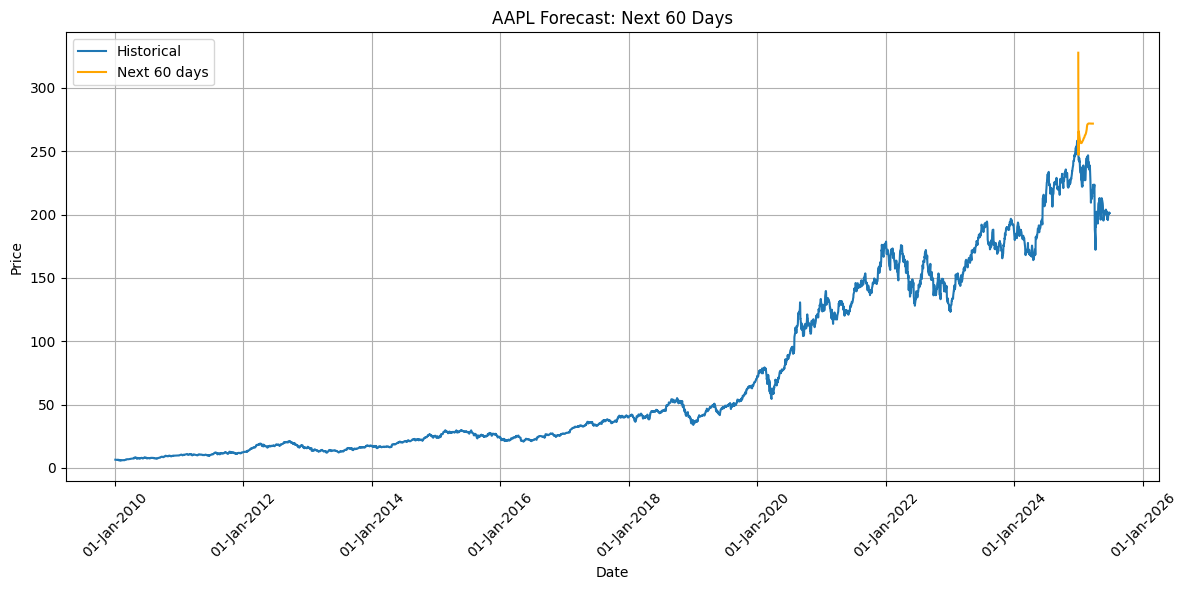

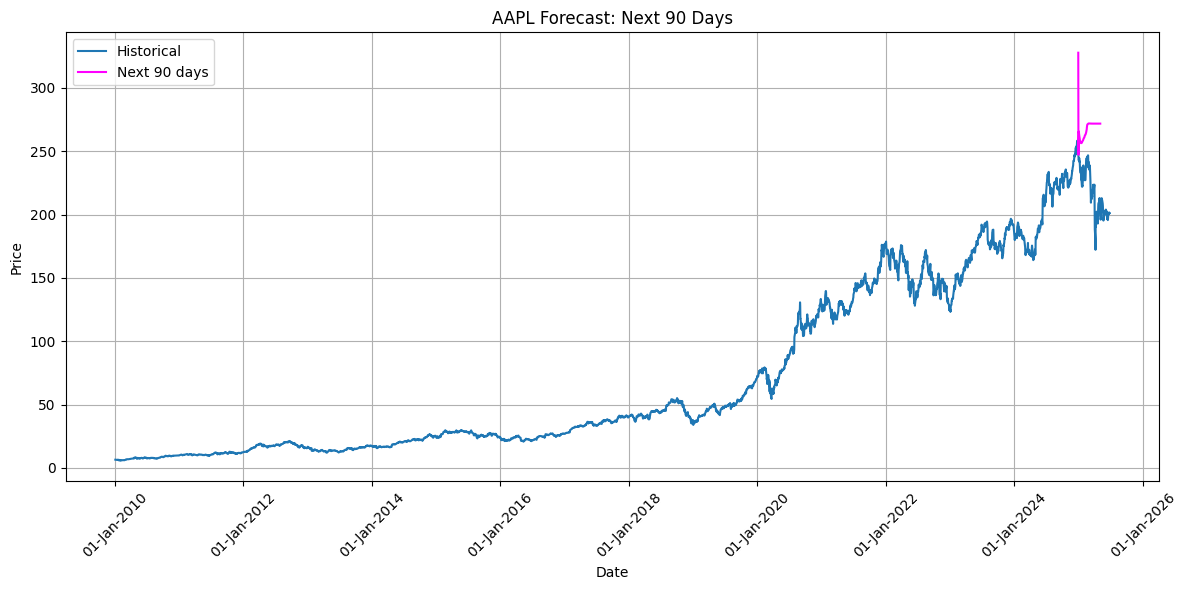

In [10]:
import matplotlib.dates as mdates

# Historical data for plotting
historical_dates = df.index
historical_prices = df['Close']

# =======================
# Next 30 days forecast
# =======================
plt.figure(figsize=(12, 6))
plt.plot(historical_dates, historical_prices, label='Historical')
plt.plot(future_dates[:30], future_pred[:30], color='red', label='Next 30 days')

# Format x-axis dates
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d-%b-%Y'))
plt.xticks(rotation=45)

plt.title('AAPL Forecast: Next 30 Days')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# =======================
# Next 60 days forecast
# =======================
plt.figure(figsize=(12, 6))
plt.plot(historical_dates, historical_prices, label='Historical')
plt.plot(future_dates[:60], future_pred[:60], color='orange', label='Next 60 days')

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d-%b-%Y'))
plt.xticks(rotation=45)

plt.title('AAPL Forecast: Next 60 Days')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# =======================
# Next 90 days forecast
# =======================
plt.figure(figsize=(12, 6))
plt.plot(historical_dates, historical_prices, label='Historical')
plt.plot(future_dates, future_pred, color='magenta', label='Next 90 days')

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d-%b-%Y'))
plt.xticks(rotation=45)

plt.title('AAPL Forecast: Next 90 Days')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


[*********************100%***********************]  1 of 1 completed


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


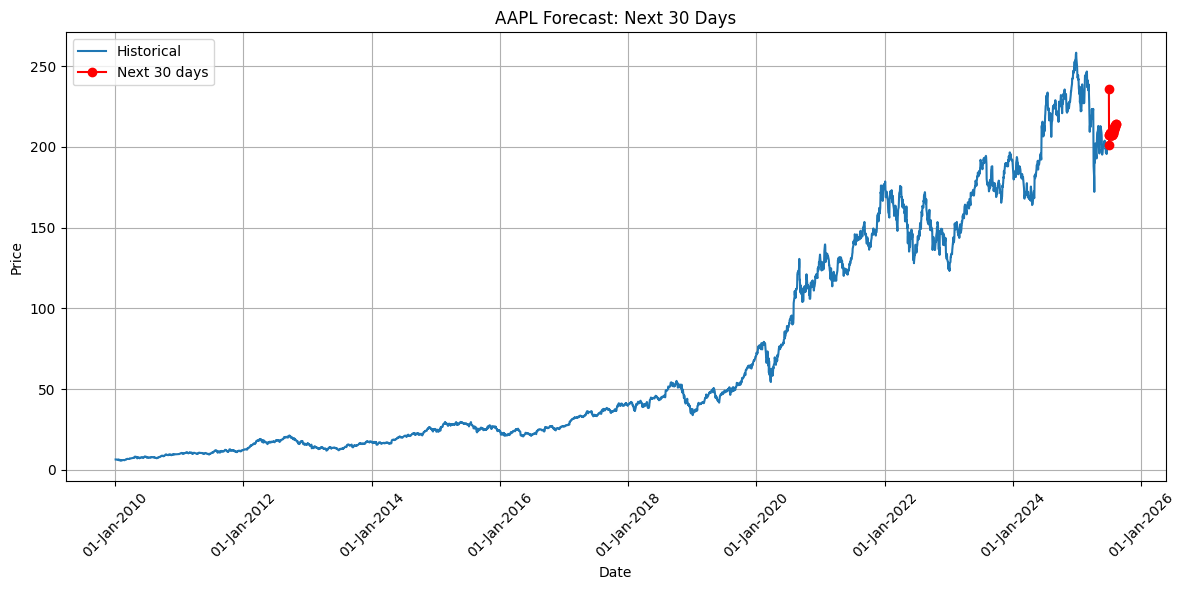

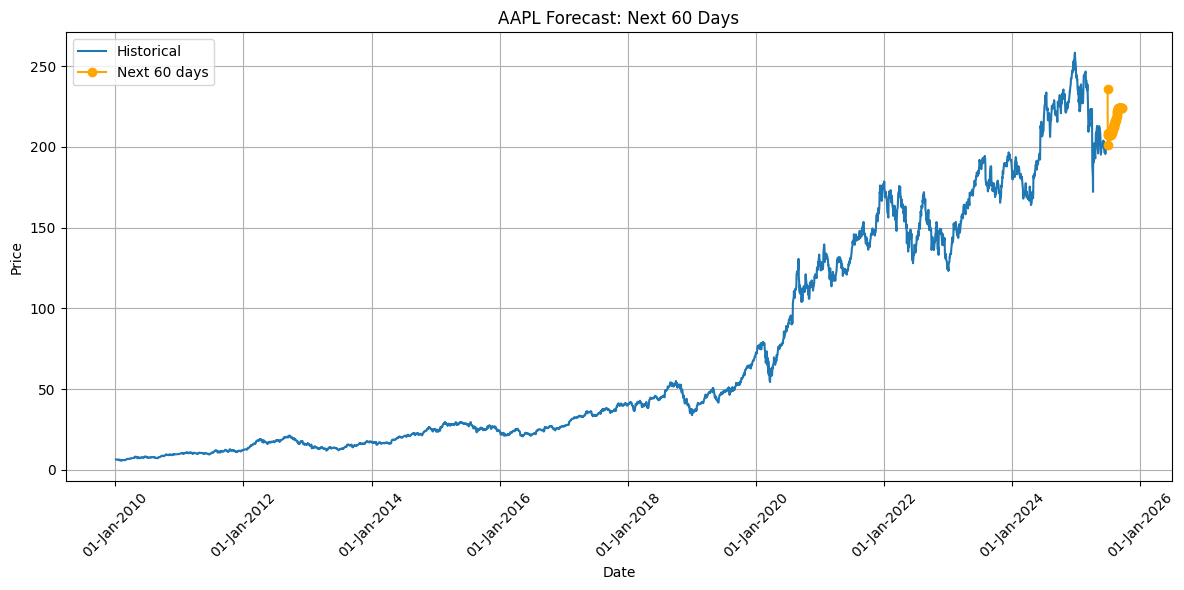

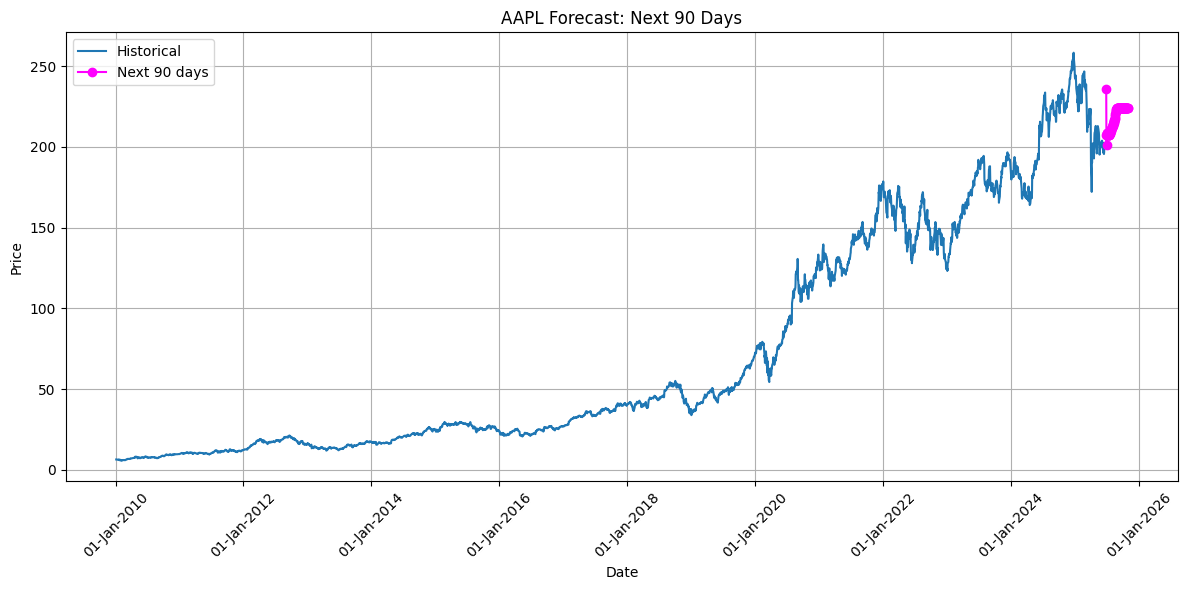

In [12]:
from keras.models import load_model
import keras
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.preprocessing import MinMaxScaler

# ================================
# 1. Load saved model
# ================================
model = load_model("seq2seq_lstm_stock_forecast.h5", compile=False)
model.compile(optimizer='adam', loss=keras.losses.MeanSquaredError())

# ================================
# 2. Load data till 30-06-2025
# ================================
TICKER = 'AAPL'
START = '2010-01-01'
END = '2025-06-30'

df = yf.download(TICKER, start=START, end=END)
df = df[['Close']].dropna()

# Fit scaler on all data
scaler = MinMaxScaler()
scaled_close = scaler.fit_transform(df[['Close']])

# ================================
# 3. Predict future (90 days)
# ================================
N_STEPS_IN = 100
N_STEPS_OUT = 90

last_seq = scaled_close[-N_STEPS_IN:].reshape(1, N_STEPS_IN, 1)
future_pred_scaled = model.predict(last_seq)
future_pred = scaler.inverse_transform(future_pred_scaled.reshape(-1, 1)).flatten()

# Generate future dates
future_dates = pd.date_range(df.index[-1] + pd.Timedelta(days=1),
                             periods=N_STEPS_OUT, freq='B')

# ================================
# 4. Plot SEPARATE graphs for 30, 60, 90 days
# ================================

# ---- 30 Days ----
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Close'], label='Historical')
plt.plot(future_dates[:30], future_pred[:30], color='red', marker='o', label='Next 30 days')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d-%b-%Y'))
plt.xticks(rotation=45)
plt.title(f"{TICKER} Forecast: Next 30 Days")
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# ---- 60 Days ----
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Close'], label='Historical')
plt.plot(future_dates[:60], future_pred[:60], color='orange', marker='o', label='Next 60 days')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d-%b-%Y'))
plt.xticks(rotation=45)
plt.title(f"{TICKER} Forecast: Next 60 Days")
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# ---- 90 Days ----
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Close'], label='Historical')
plt.plot(future_dates, future_pred, color='magenta', marker='o', label='Next 90 days')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d-%b-%Y'))
plt.xticks(rotation=45)
plt.title(f"{TICKER} Forecast: Next 90 Days")
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


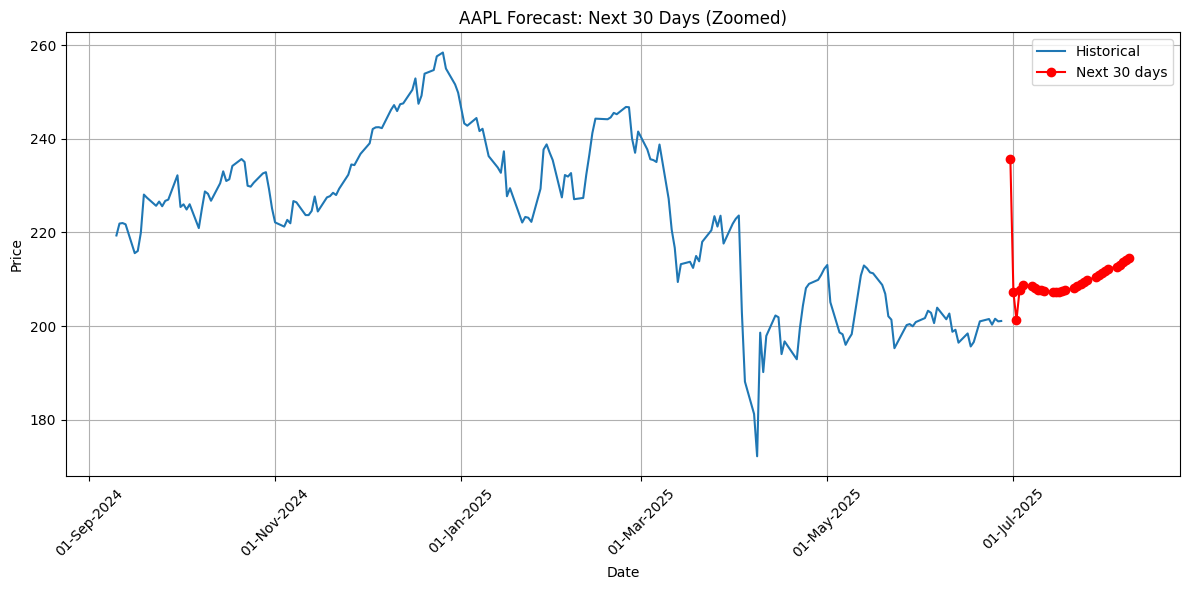

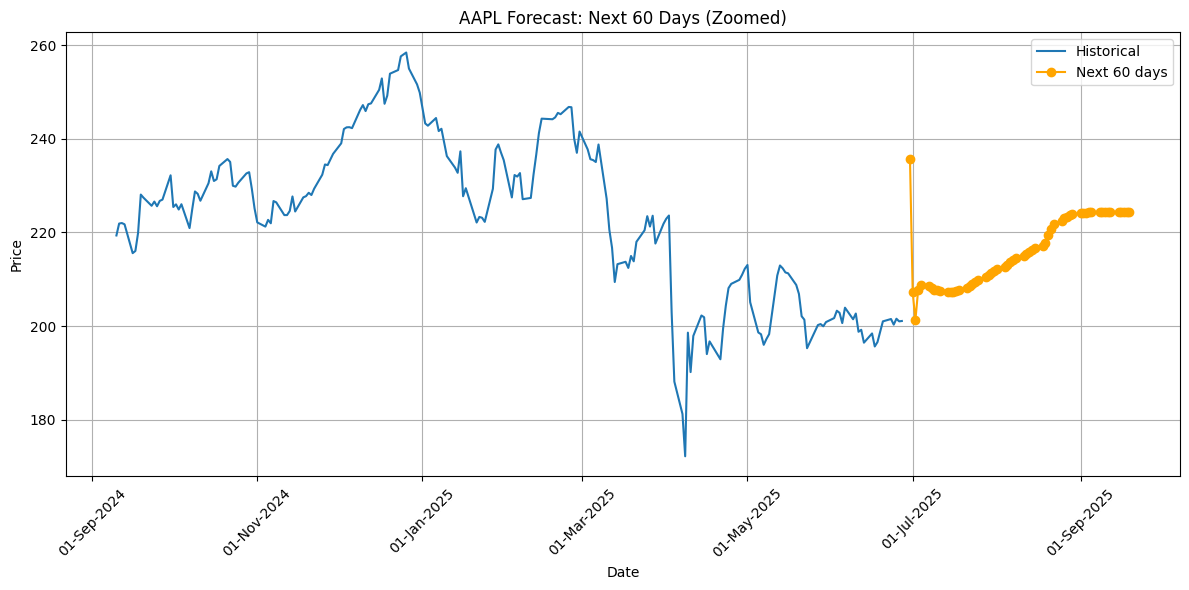

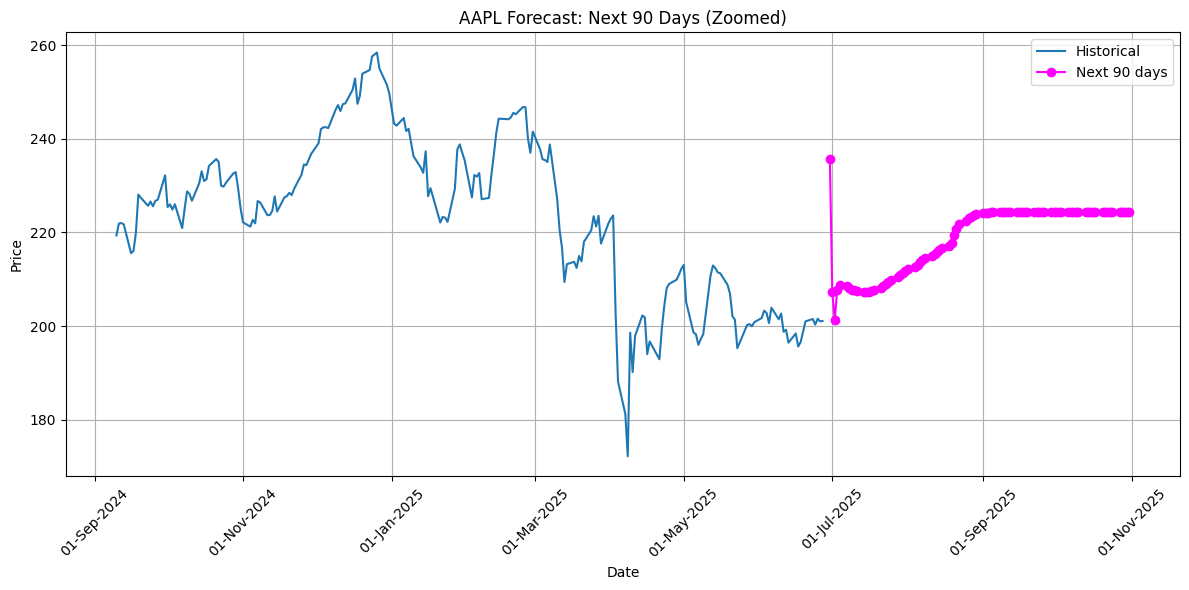

✅ CSV files saved: forecast_30_days.csv, forecast_60_days.csv, forecast_90_days.csv


In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# --- 30 Days ---
plt.figure(figsize=(12, 6))
plt.plot(df.index[-200:], df['Close'][-200:], label='Historical')
plt.plot(future_dates[:30], future_pred[:30], color='red', marker='o', label='Next 30 days')

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d-%b-%Y'))
plt.xticks(rotation=45)
plt.title(f"{TICKER} Forecast: Next 30 Days (Zoomed)")
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Save CSV for 30 days
pred_30 = pd.DataFrame({'Date': future_dates[:30], 'Predicted Price': future_pred[:30]})
pred_30.to_csv('forecast_30_days.csv', index=False)

# --- 60 Days ---
plt.figure(figsize=(12, 6))
plt.plot(df.index[-200:], df['Close'][-200:], label='Historical')
plt.plot(future_dates[:60], future_pred[:60], color='orange', marker='o', label='Next 60 days')

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d-%b-%Y'))
plt.xticks(rotation=45)
plt.title(f"{TICKER} Forecast: Next 60 Days (Zoomed)")
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Save CSV for 60 days
pred_60 = pd.DataFrame({'Date': future_dates[:60], 'Predicted Price': future_pred[:60]})
pred_60.to_csv('forecast_60_days.csv', index=False)

# --- 90 Days ---
plt.figure(figsize=(12, 6))
plt.plot(df.index[-200:], df['Close'][-200:], label='Historical')
plt.plot(future_dates, future_pred, color='magenta', marker='o', label='Next 90 days')

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d-%b-%Y'))
plt.xticks(rotation=45)
plt.title(f"{TICKER} Forecast: Next 90 Days (Zoomed)")
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Save CSV for 90 days
pred_90 = pd.DataFrame({'Date': future_dates, 'Predicted Price': future_pred})
pred_90.to_csv('forecast_90_days.csv', index=False)

print("✅ CSV files saved: forecast_30_days.csv, forecast_60_days.csv, forecast_90_days.csv")
